Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [2]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [3]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [4]:
plt.rcParams["font.size"] = 18

# Preprocess

In [5]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [6]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest, region):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Delete signals of unselected region
    signal[:,list(set(range(50))-region)] = 0
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [8]:
def Get_Dataset(TRAIN, VALID, TEST, REGION):
    
    # Training dataset
    print('TRAINING')
    trainX = numpy.empty([0,50,31], dtype=numpy.float32)
    trainY = numpy.empty(0, dtype=numpy.float32)
    for i in TRAIN:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], REGION)
            trainX = numpy.concatenate([trainX, X], axis=0)
            trainY = numpy.concatenate([trainY, Y], axis=0)

    # Validation dataset
    print('VALIDATION')
    validX = numpy.empty([0,50,31], dtype=numpy.float32)
    validY =numpy.empty(0, dtype=numpy.float32)
    for i in VALID:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j], REGION)
            validX = numpy.concatenate([validX, X], axis=0)
            validY = numpy.concatenate([validY, Y], axis=0)

    return trainX, validX, trainY, validY

# Training

In [9]:
# region number to index
def region_index(region_num):
    region_index = []
    for re in region_num:
        region_index.append(re - 1)
    return set(region_index)

In [10]:
# Select 4 regions
selected_region = [6,8,31,33]

In [11]:
# Region number
WHOLE = list(range(1,51))
FOUR = selected_region
OTHER = list(set(WHOLE)-set(selected_region))
print(WHOLE)
print(FOUR)
print(OTHER)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[6, 8, 31, 33]
[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [12]:
from Training_code_behavior import Learn_model_region

In [13]:
REGIONS = {'Whole_region':region_index(WHOLE), 'Region_6-8-31-33':region_index(FOUR), 'Other_than_4_regions':region_index(OTHER)}

In [14]:
Models = ['GRU']

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 1


Using TensorFlow backend.
TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


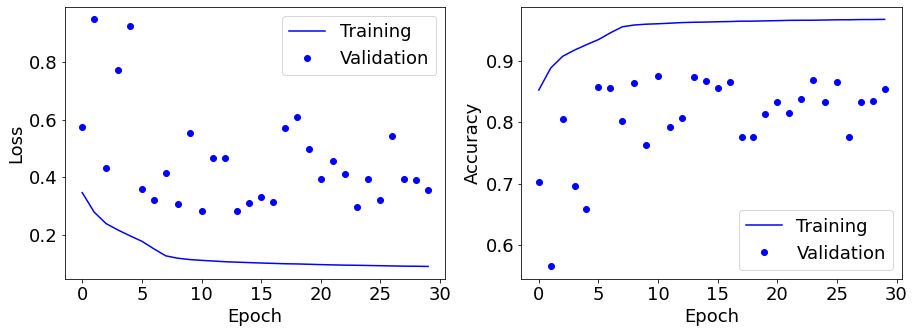

{32, 5, 30, 7}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


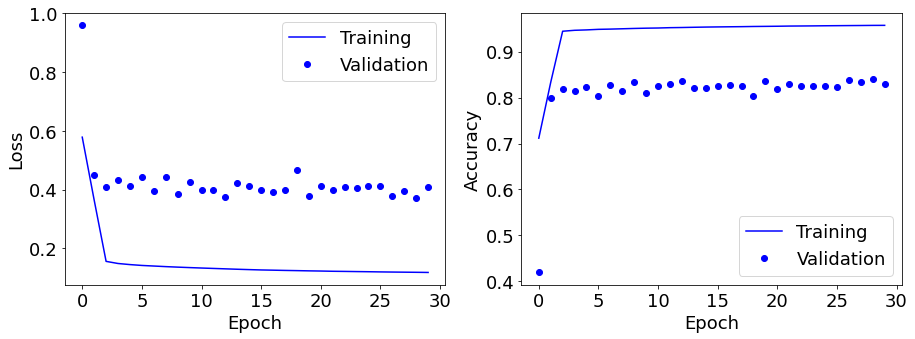

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


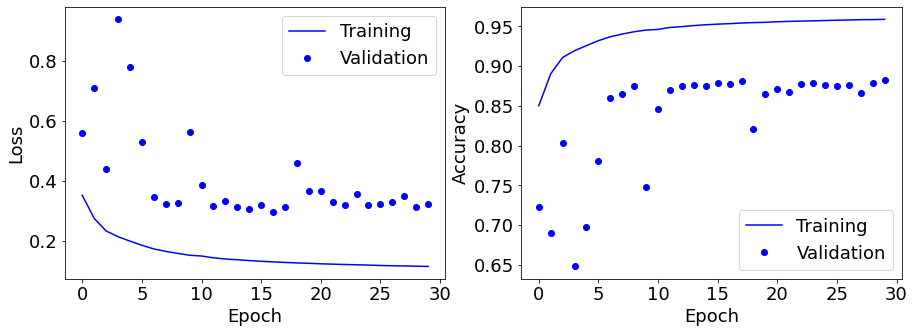

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


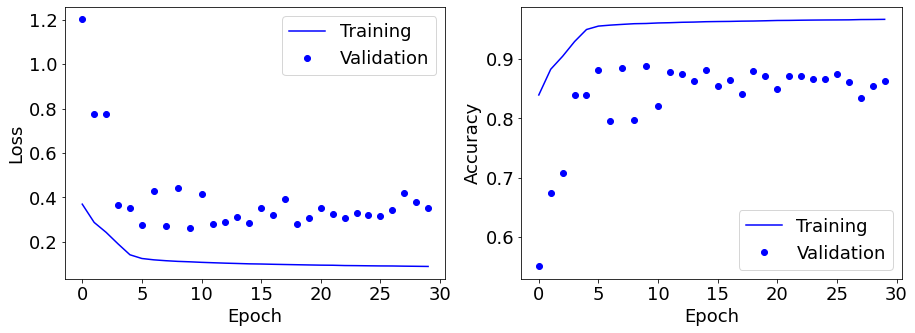

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


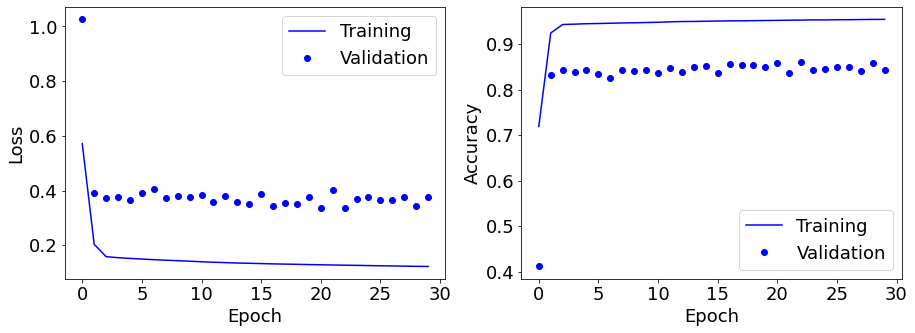

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


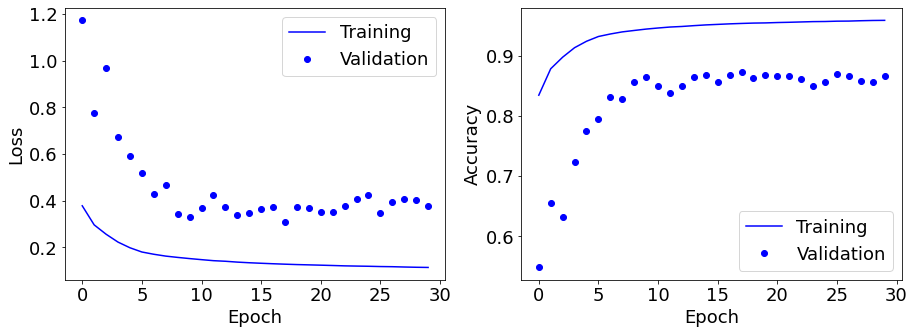

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


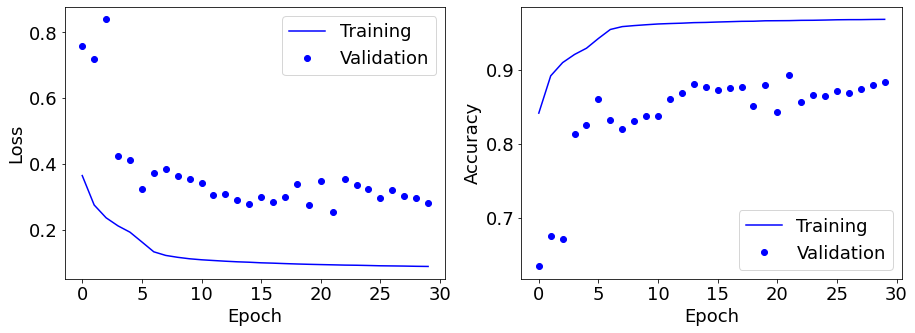

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


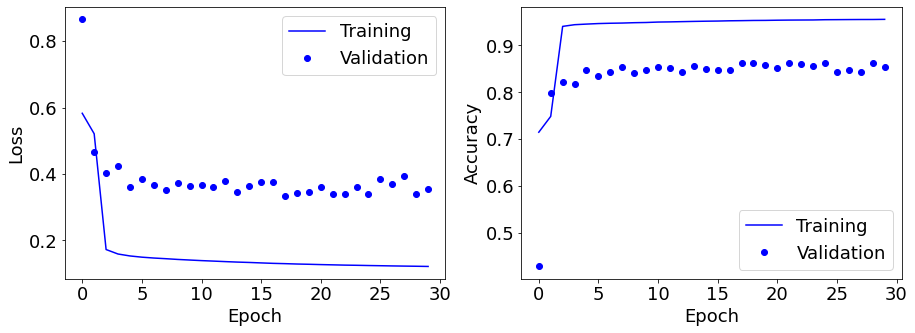

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


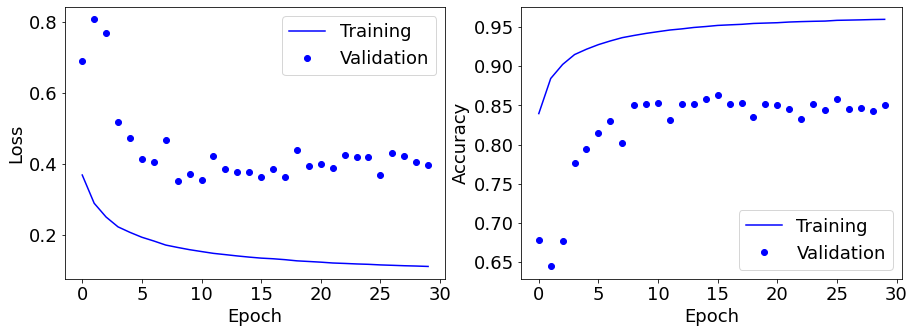

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


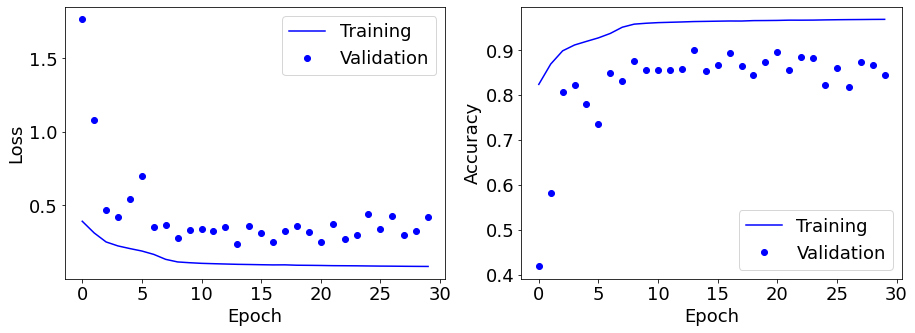

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


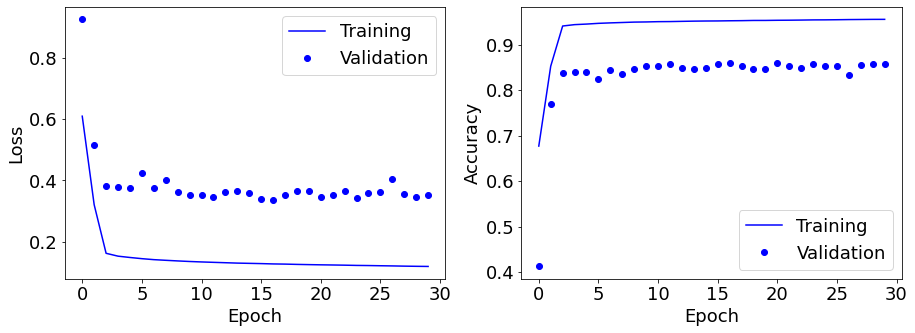

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 1


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


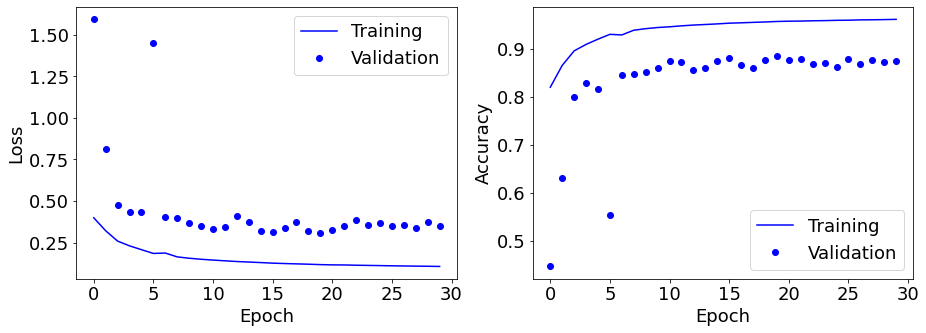

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


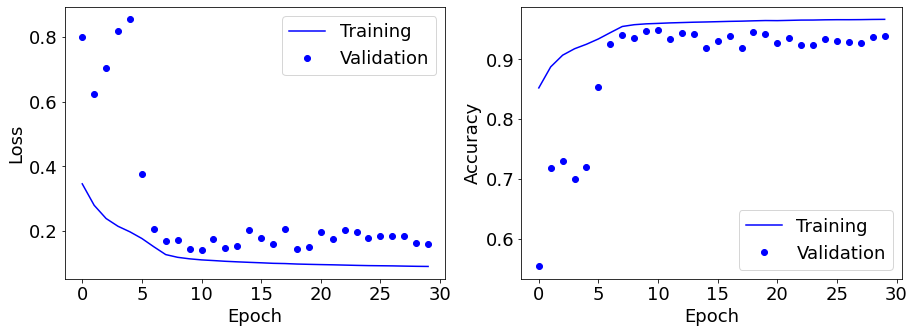

{32, 5, 30, 7}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


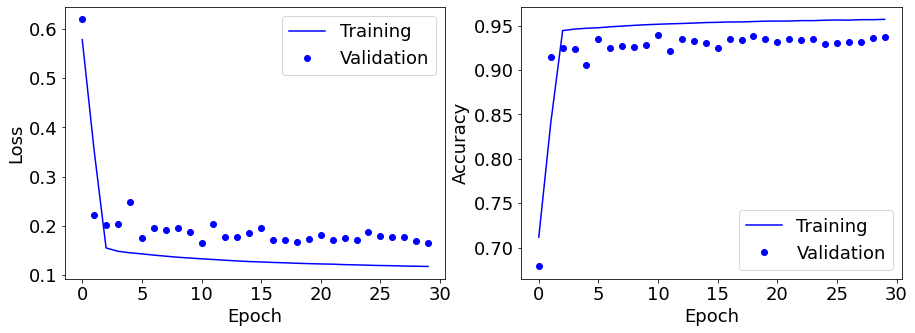

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 3
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


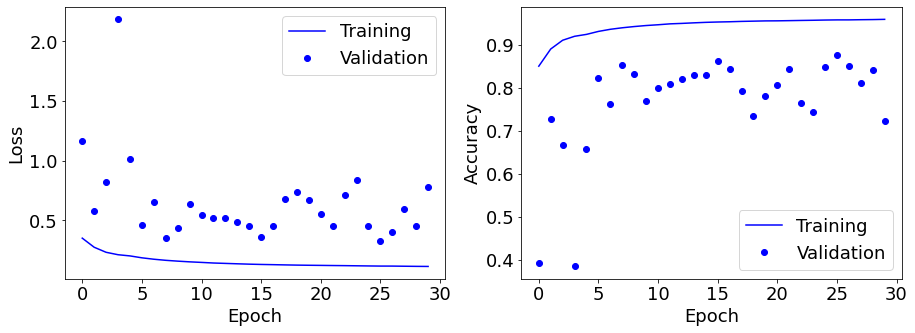

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


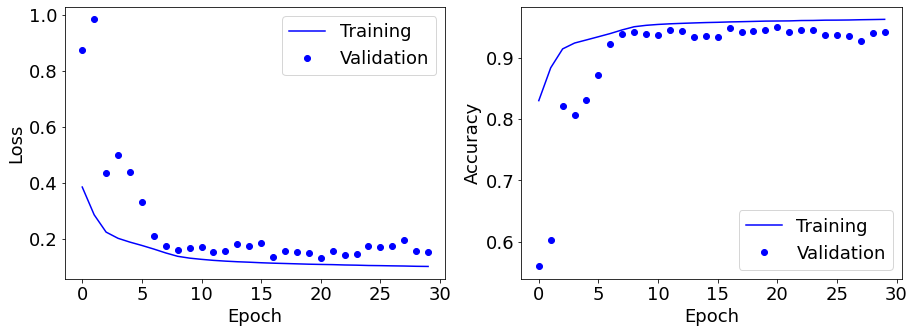

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


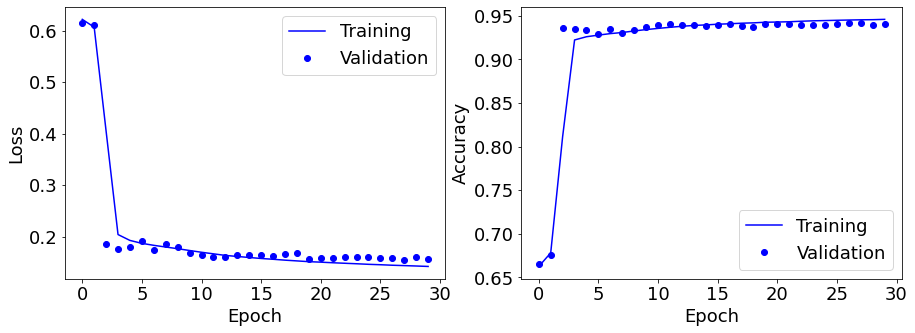

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


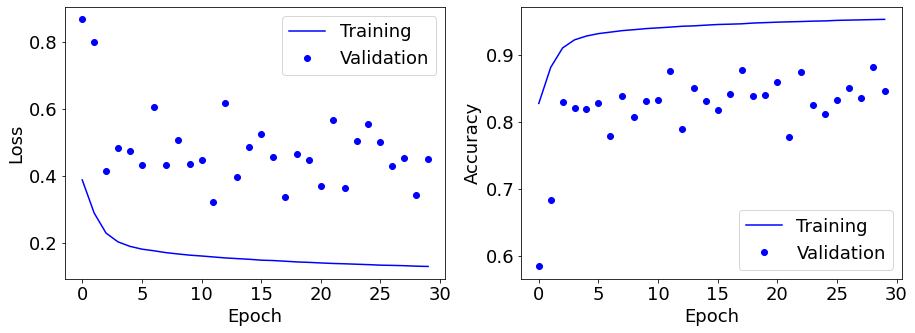

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


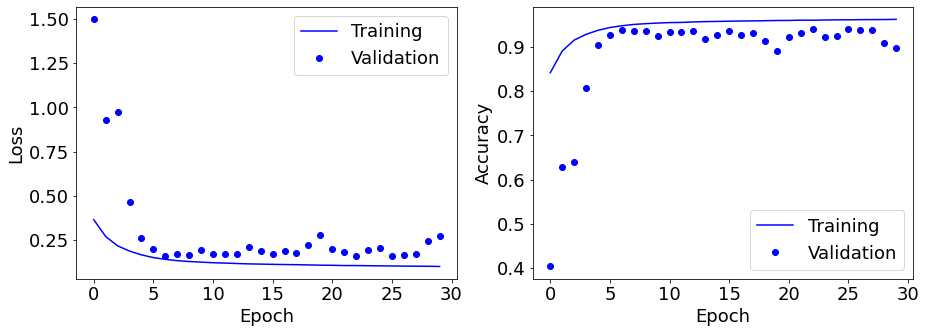

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


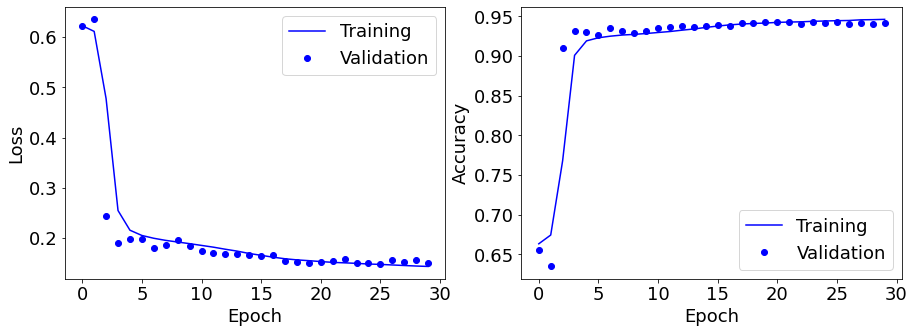

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


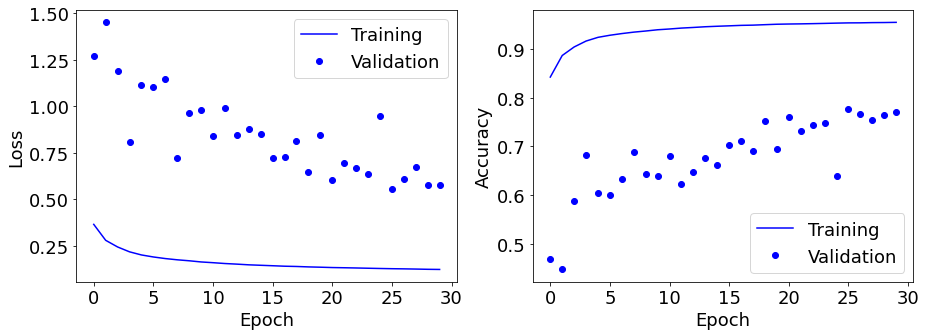

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


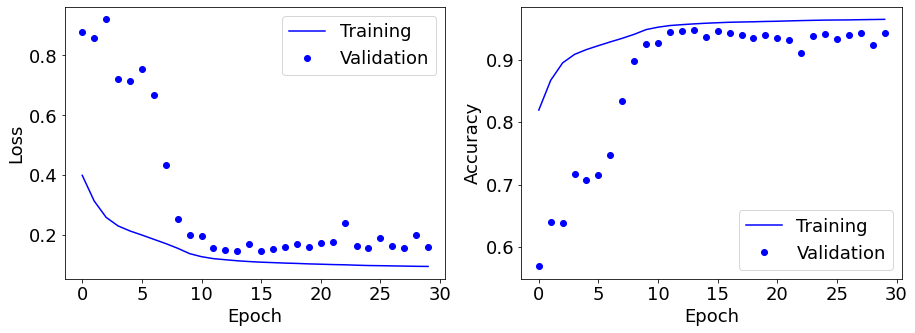

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


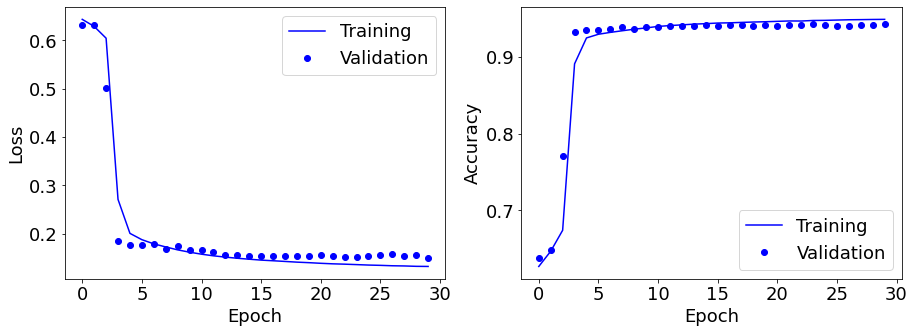

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 2


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


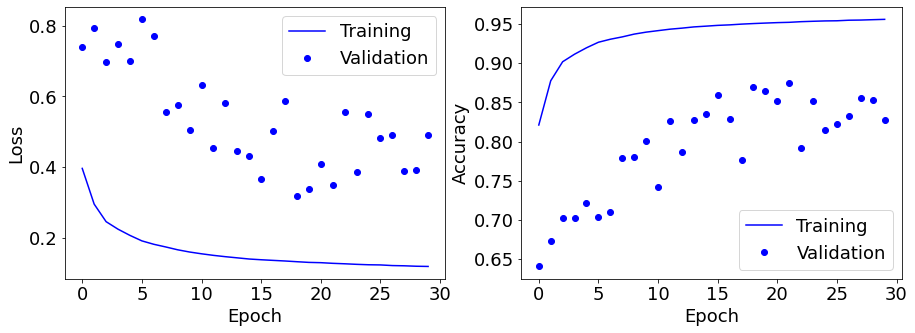

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


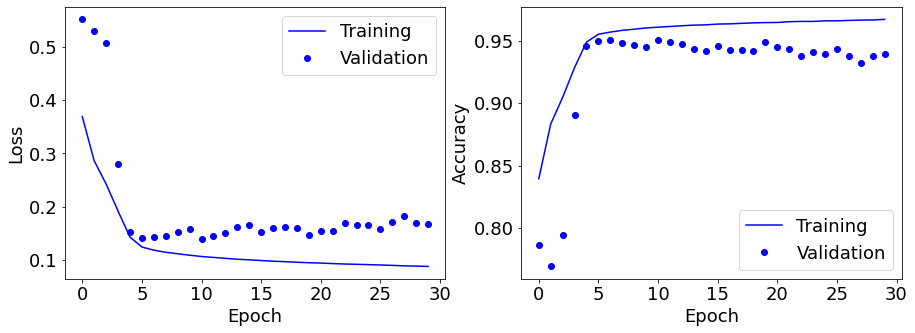

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


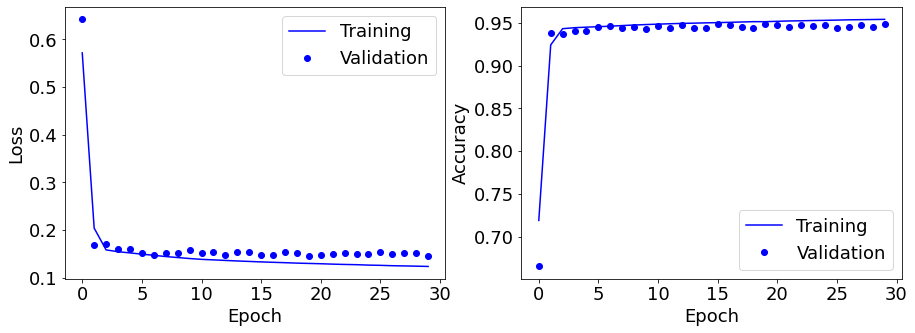

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


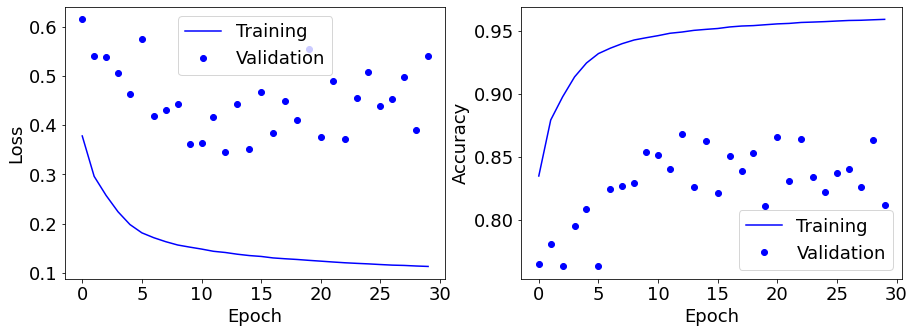

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


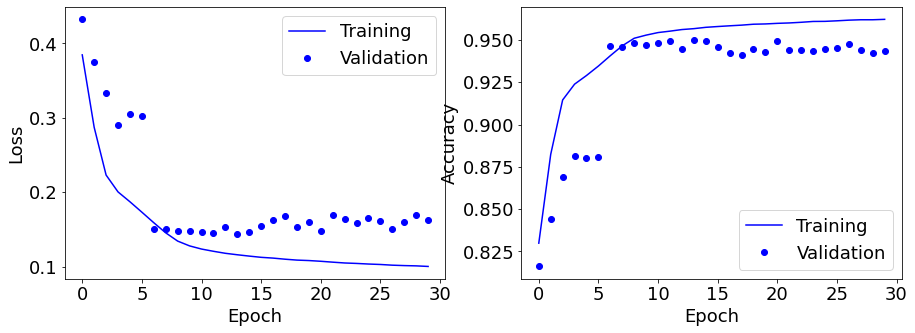

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


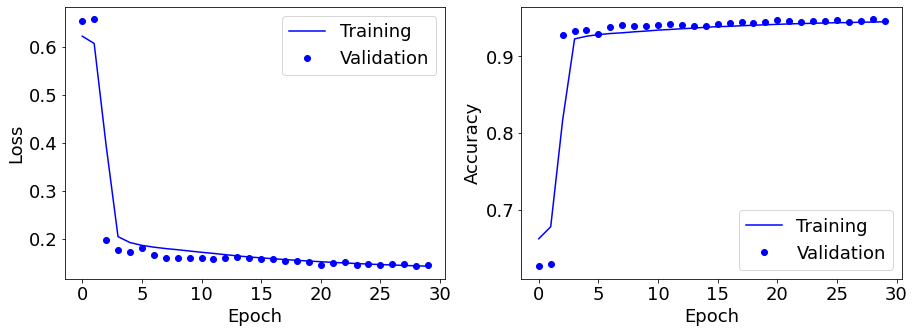

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 4
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


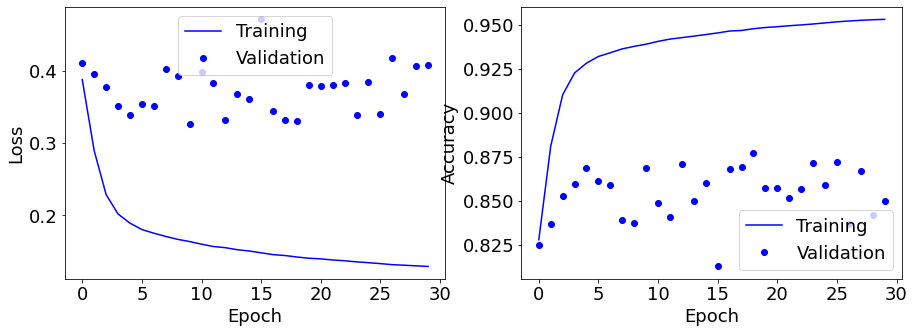

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


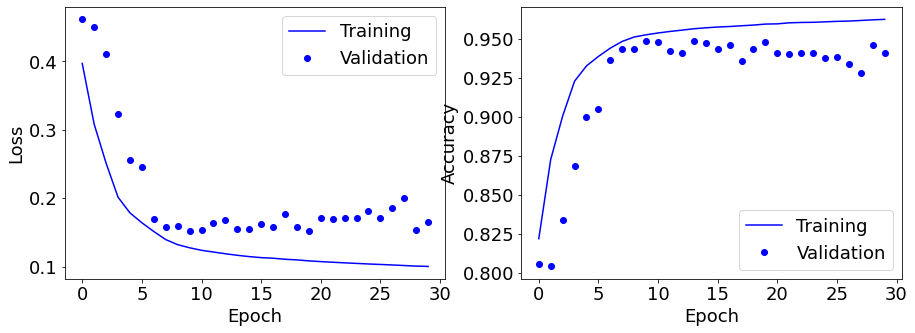

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


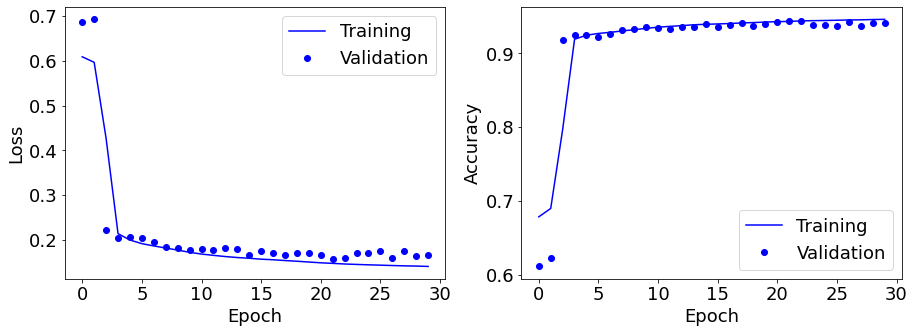

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


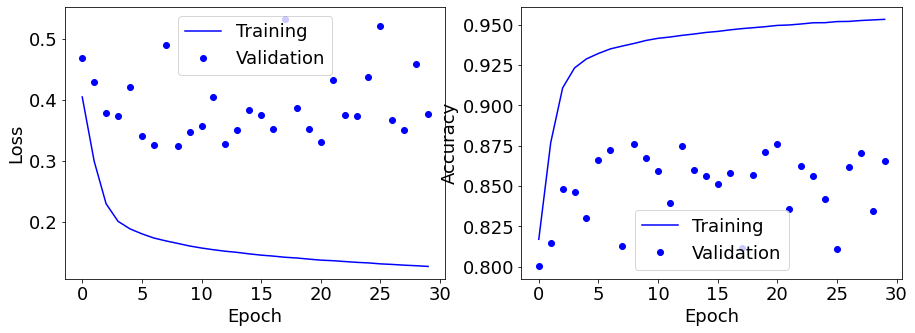

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


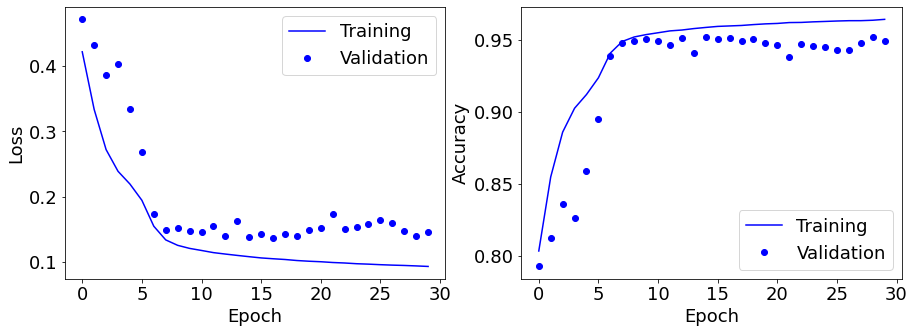

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


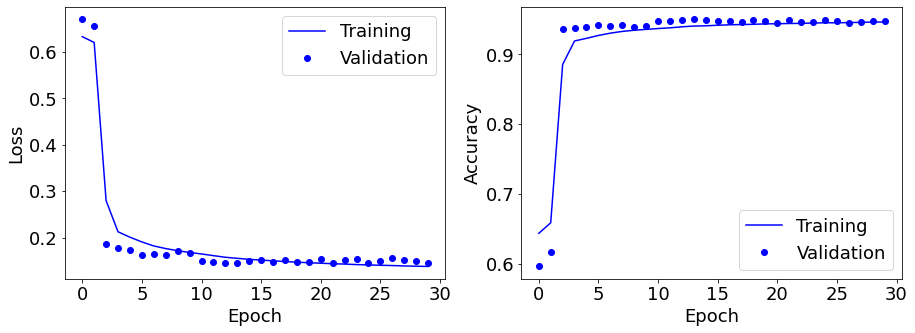

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 3


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


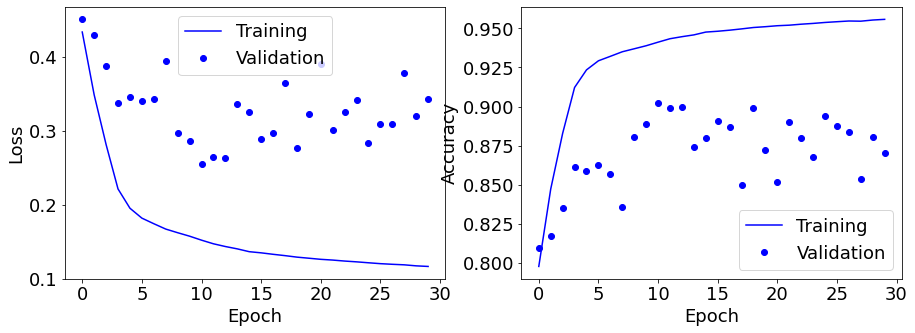

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


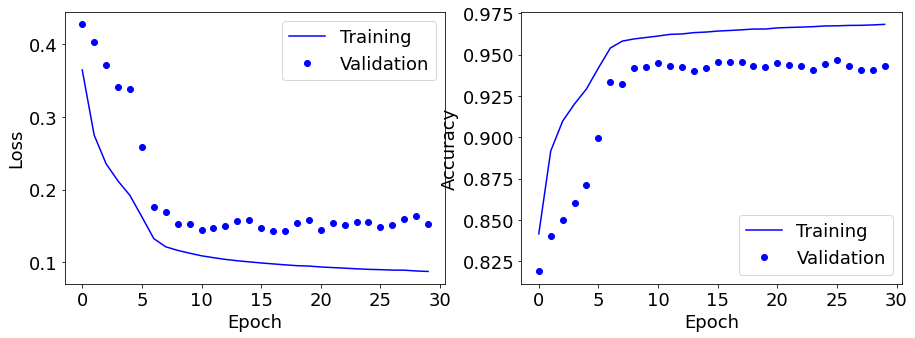

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


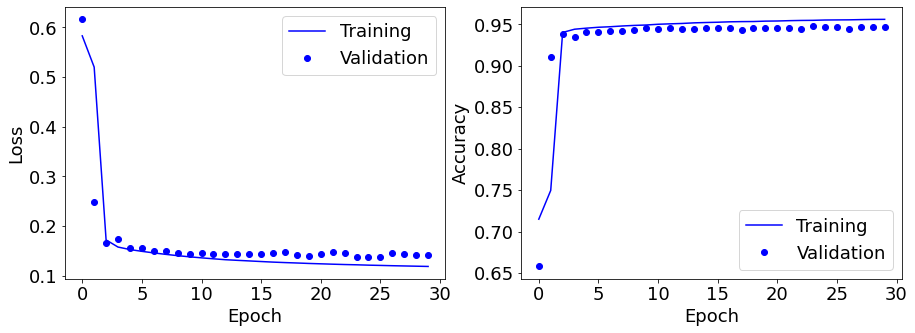

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


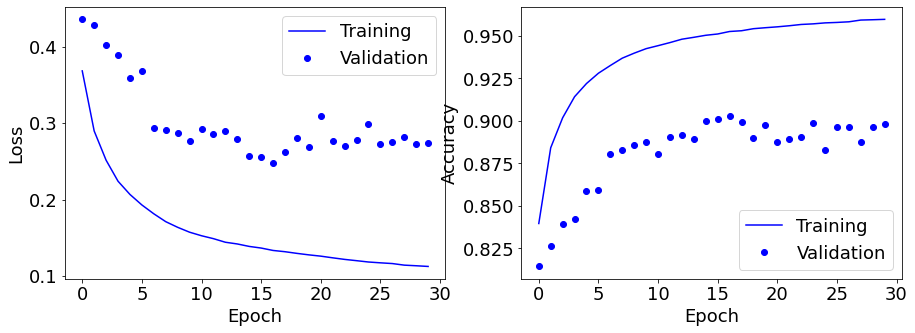

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


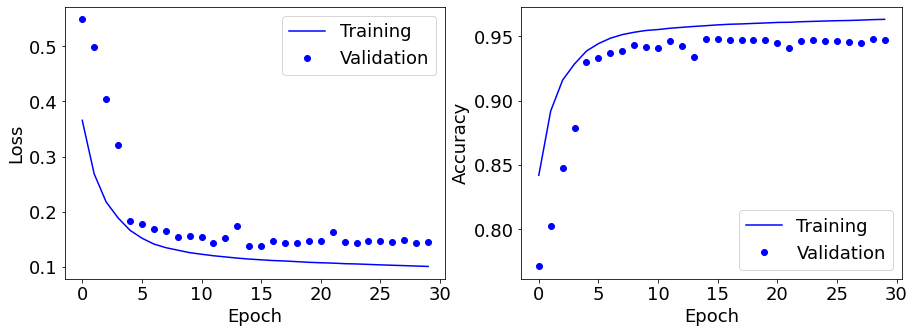

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


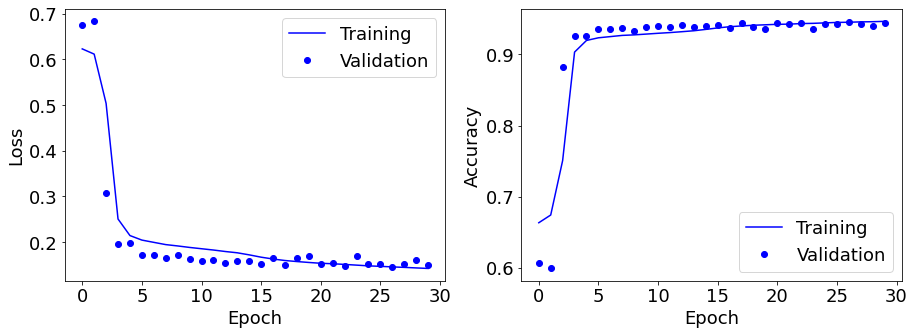

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


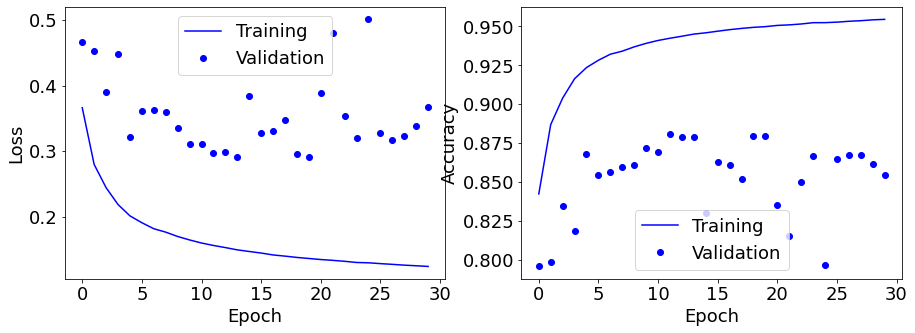

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


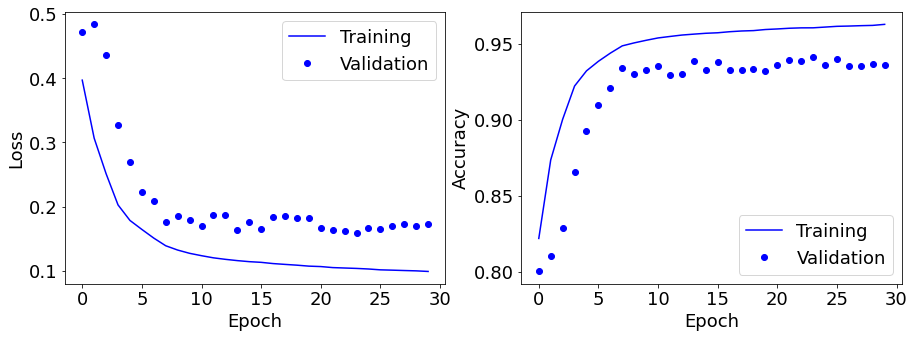

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


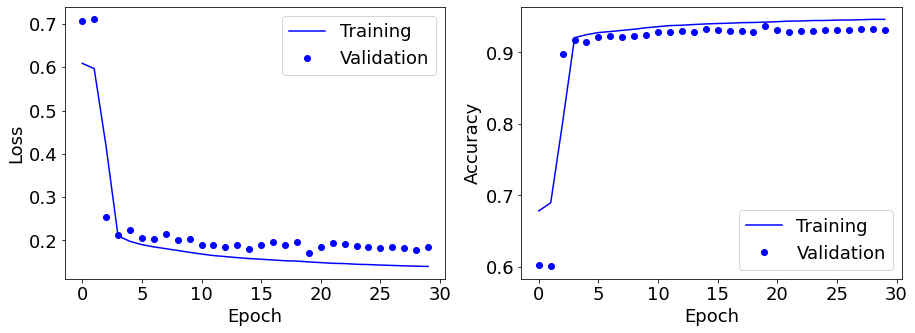

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 5
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


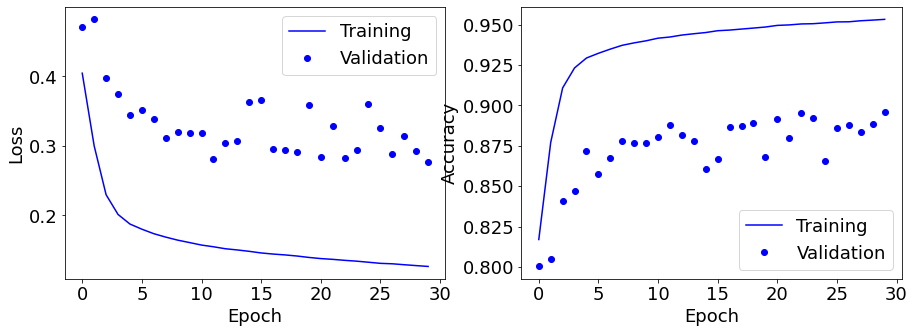

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


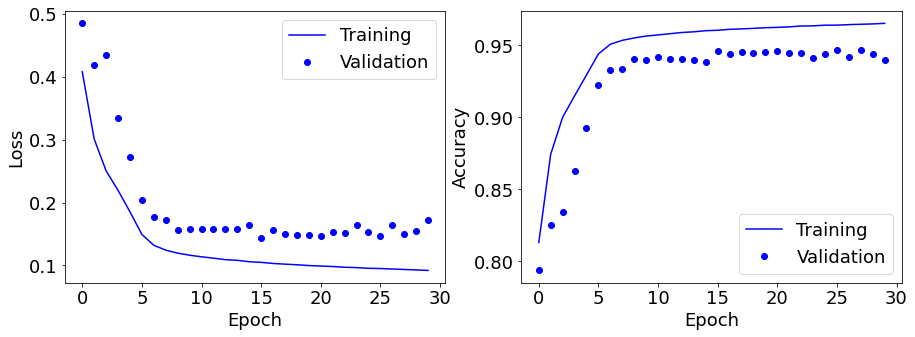

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


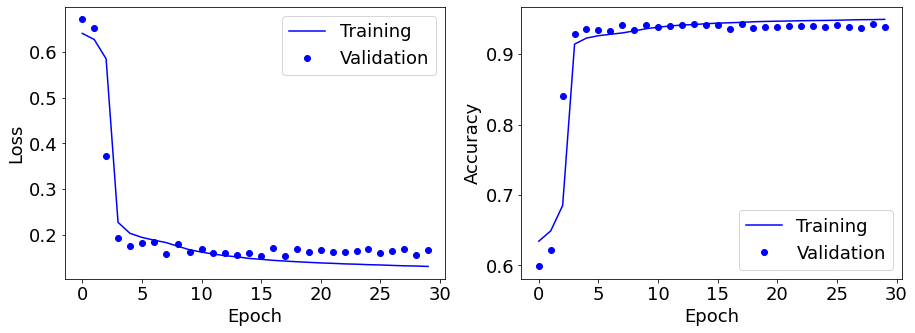

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 4


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


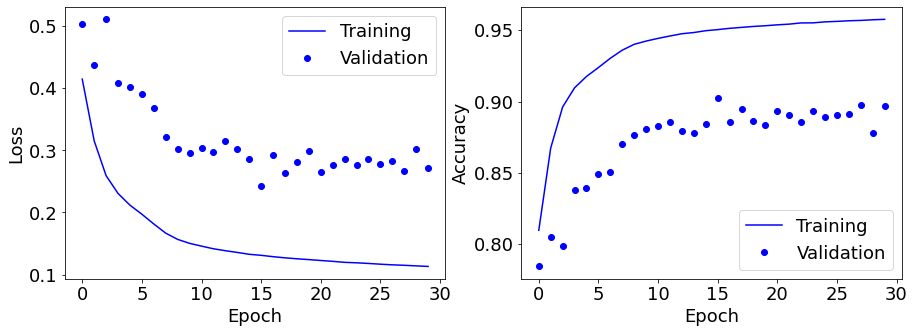

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


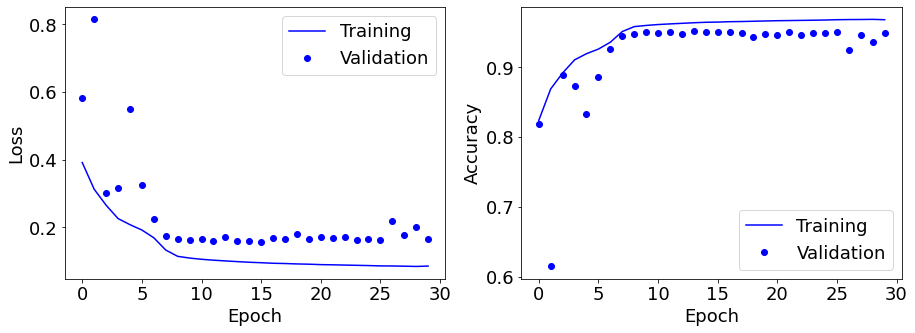

{32, 5, 30, 7}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


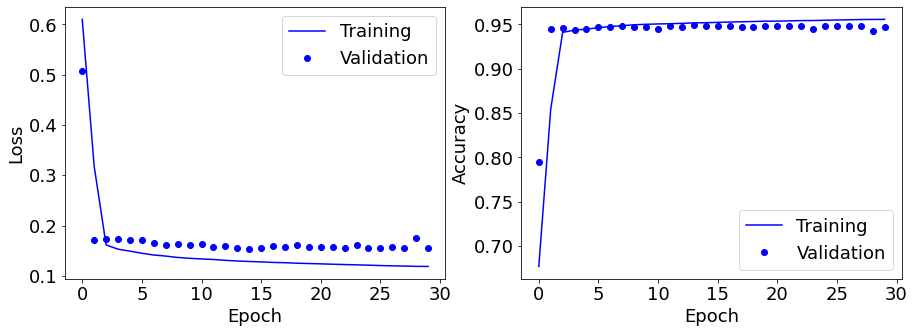

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 2
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


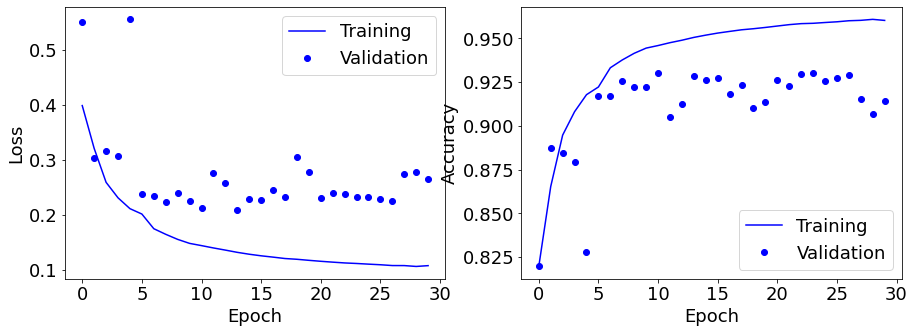

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


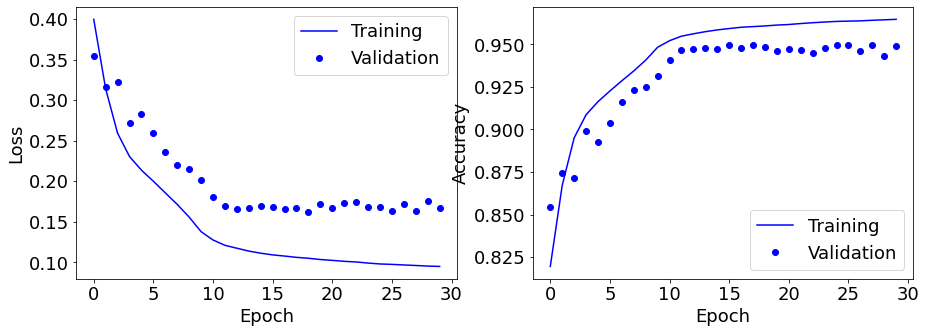

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


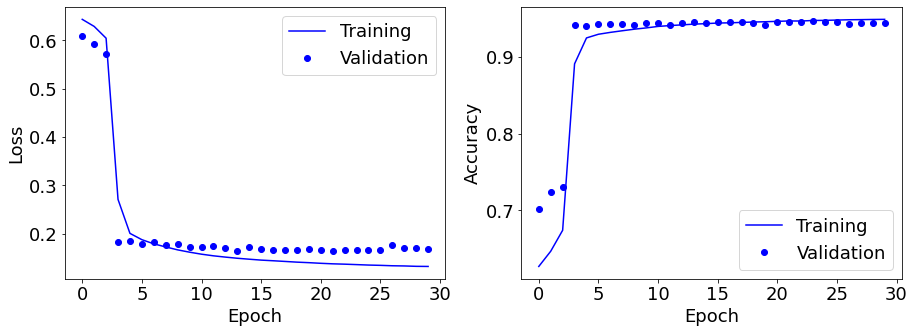

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 3
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


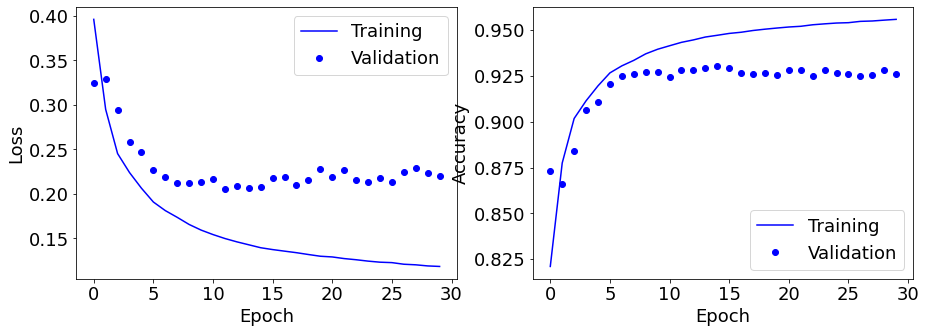

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


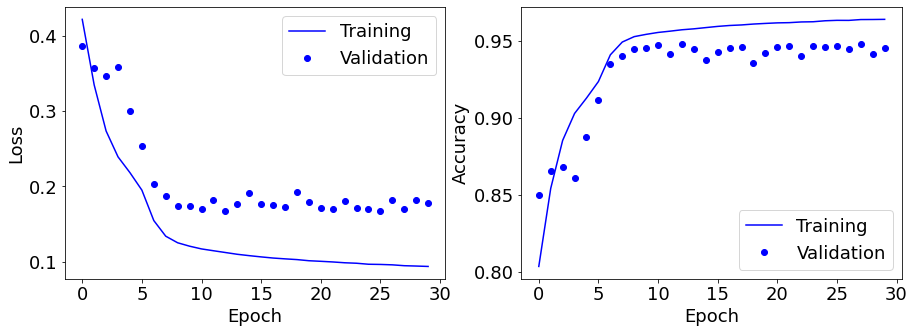

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


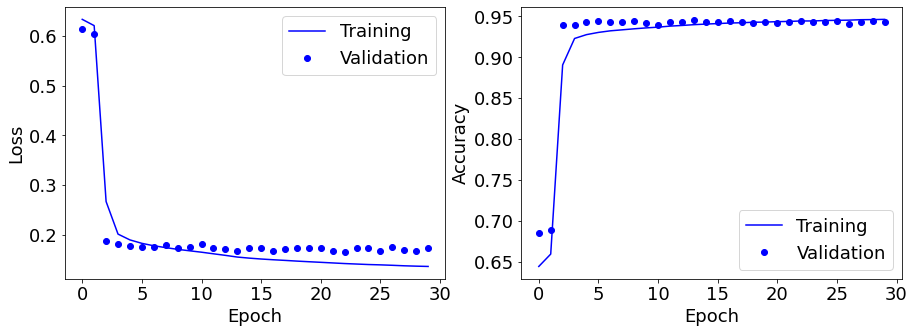

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 4
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


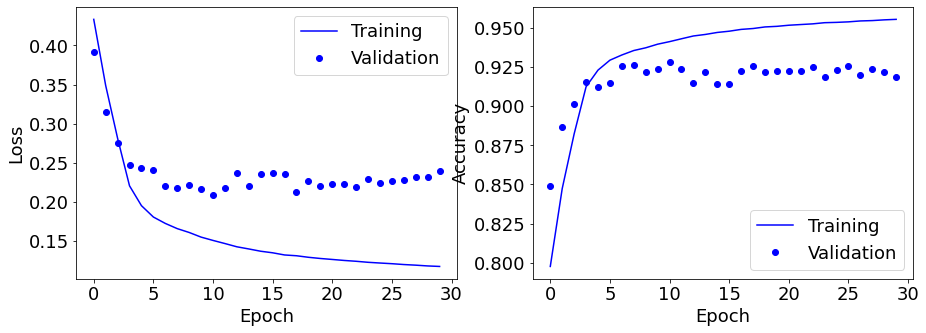

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


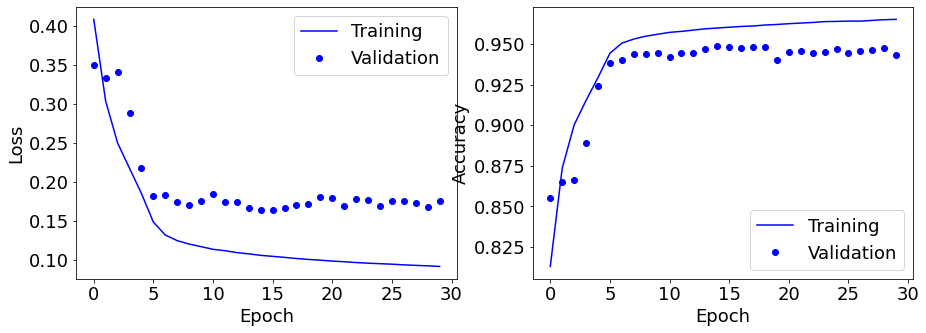

{32, 5, 30, 7}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


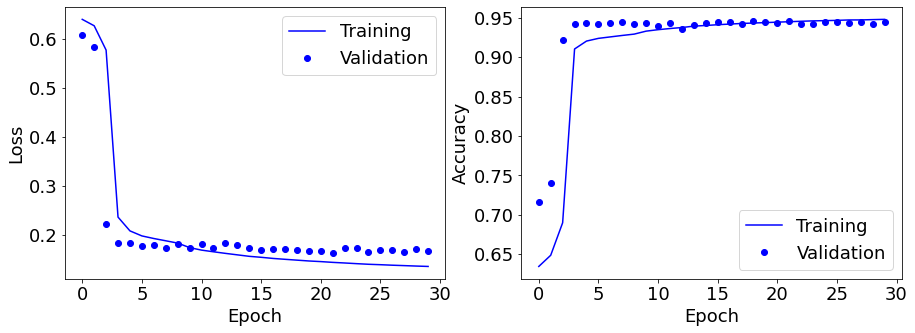

{0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
TRAINING
Mouse 1
Mouse 2
Mouse 3
VALIDATION
Mouse 5


TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


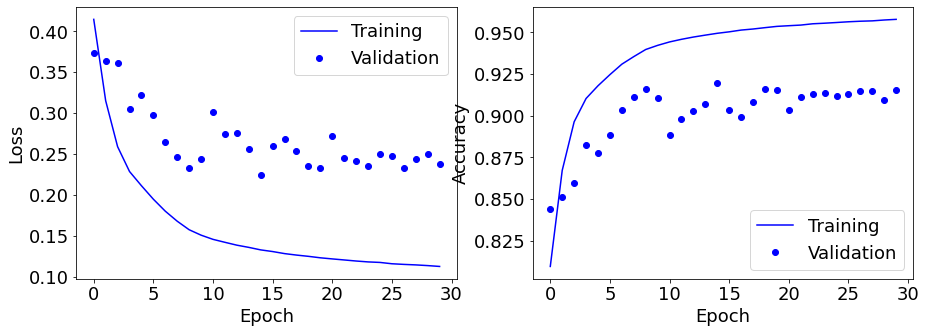

In [15]:
import itertools
l = [1, 2, 3, 4, 5]
for v in itertools.permutations(l, 2):
    TRAIN = [i for i in l if i not in v]
    VALID = [v[0]]
    TEST = [v[1]]
    for REGION in REGIONS:
        print(REGIONS[REGION])
        trainX, validX, trainY, validY = Get_Dataset(TRAIN, VALID, TEST, REGIONS[REGION])
        for ModelType in Models:
            ver = f'{ModelType}_{VALID}_{TEST}'
            history = Learn_model_region(trainX, validX, trainY, validY, ModelType, ver, REGION)
            acc = history.history['acc']
            val_acc = history.history['val_acc']
            loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochs = range(len(acc))
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
            ax[0].plot(epochs, loss, 'b', label='Training')
            ax[0].plot(epochs, val_loss, 'bo', label='Validation')
            ax[0].set(xlabel="Epoch")
            ax[0].set(ylabel="Loss")
            ax[0].legend()
            ax[1].plot(epochs, acc, 'b', label='Training')
            ax[1].plot(epochs, val_acc, 'bo', label='Validation')
            ax[1].set(xlabel="Epoch")
            ax[1].set(ylabel="Accuracy")
            ax[1].legend()
            plt.show()